In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelEncoder
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from scipy.sparse import hstack
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [57]:
import nltk
nltk.download('punkt')       # For tokenization
nltk.download('stopwords')   # For filtering common words


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
dataset = pd.read_csv("/ResumeDataSet.csv",encoding='utf-8')
dataset.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Unique values in the 'Category' column
unique_categories = dataset['Category'].value_counts()
print("Unique categories in the dataset:", unique_categories)

Unique categories in the dataset: Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Categories')

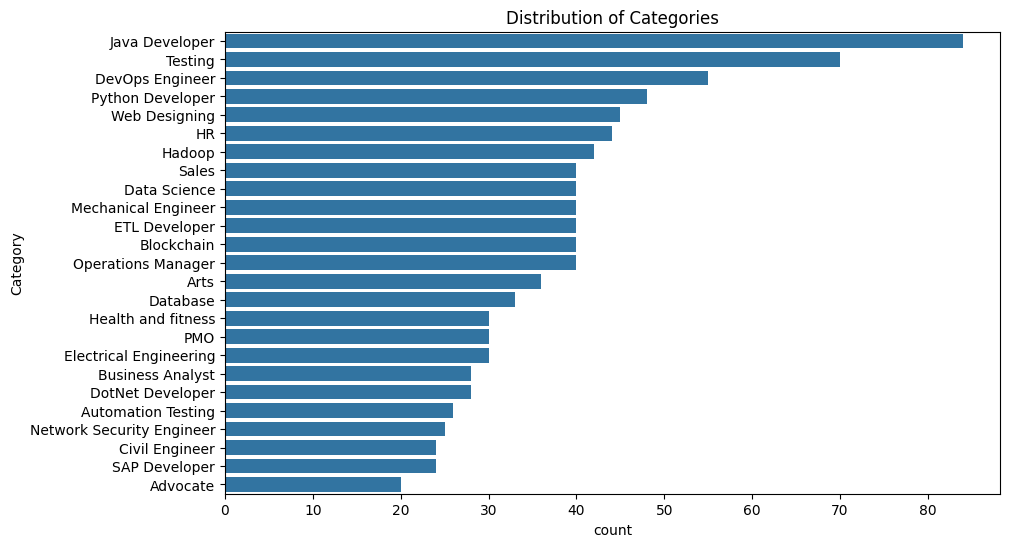

In [61]:
# Exploratory Data Analysis (EDA)

plt.figure(figsize=(10, 6))
sns.countplot(y=dataset['Category'], order=dataset['Category'].value_counts().index)
plt.title('Distribution of Categories')

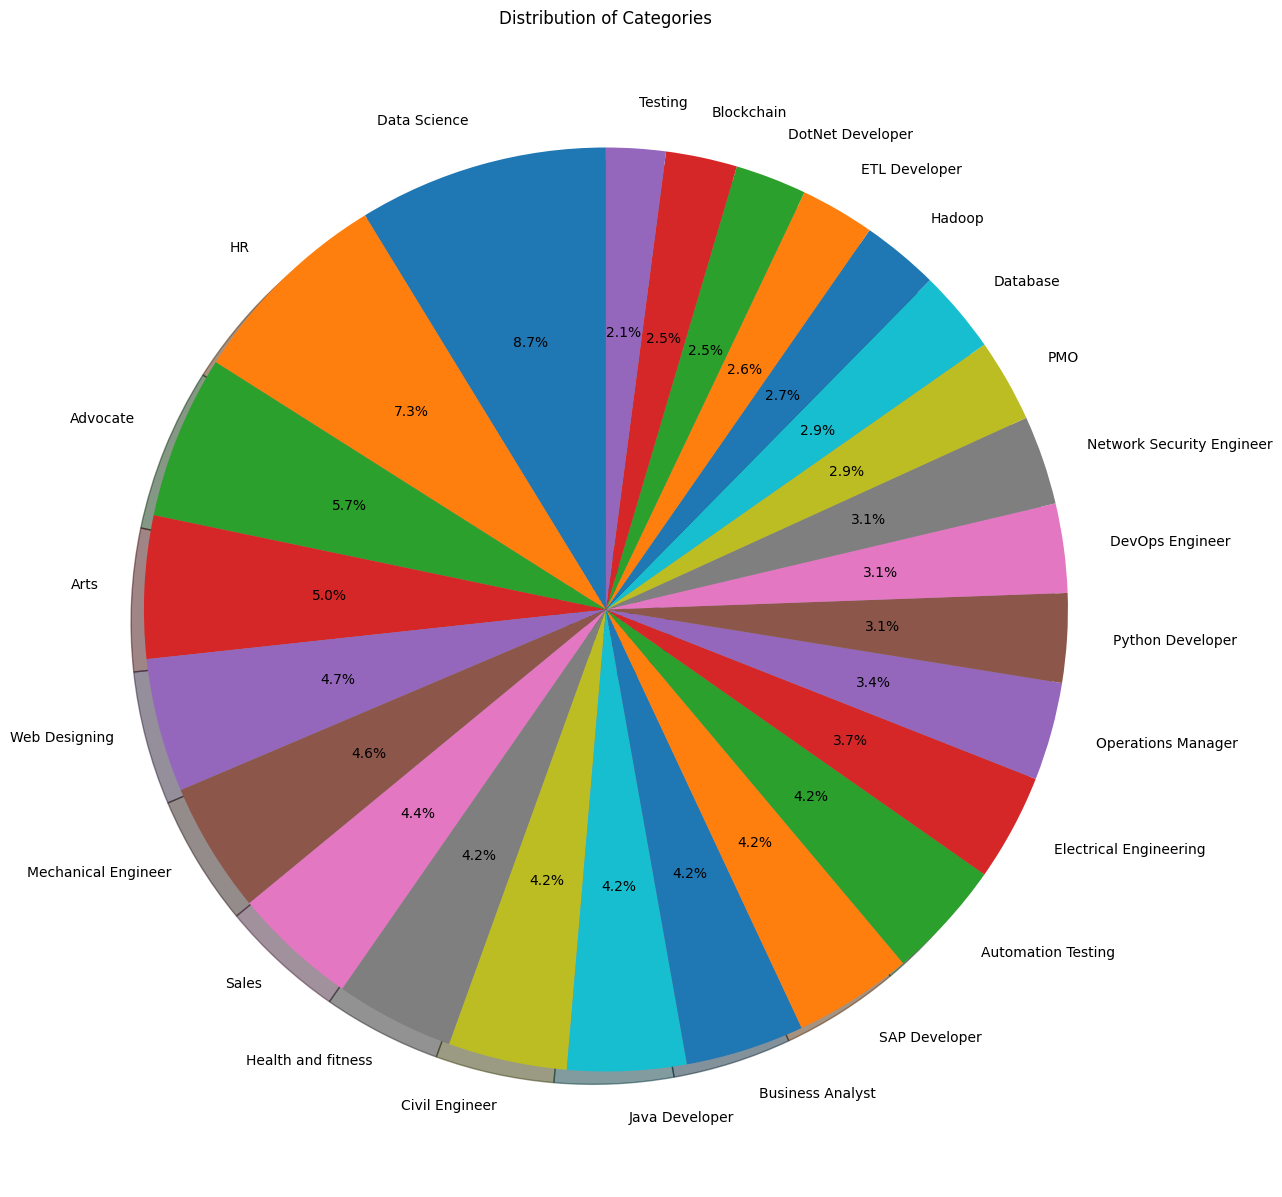

In [62]:
#Distribution of Categories
plt.figure(figsize=(15, 15))
categories=dataset['Category'].unique()
values=dataset['Category'].value_counts()
plt.pie(values,labels=categories,autopct='%1.1f%%', shadow =True, startangle=90)

plt.title('Distribution of Categories')
plt.show()

In [63]:
def clean_text(text):
    text = re.sub('http\S+\s*', ' ', text)
    text = re.sub('RT|cc', ' ', text)
    text = re.sub('#\S+', '', text)
    text = re.sub('@\S+', '  ', text)
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ',text)
    text = re.sub(r'[^\x00-\x7f]',r' ', text)
    text = re.sub('\s+', ' ', text)
    return text
dataset['clean_text'] = dataset.Resume.apply(clean_text)
dataset['clean_text']

,clean_text
0,Skills Programming Languages Python pandas num...
1,Education Details May 2013 to May 2017 B E UIT...
2,Areas of Interest Deep Learning Control System...
3,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Education Details MCA YMCAUST Faridabad Haryan...
...,...
957,Computer Skills Proficient in MS office Word B...
958,Willingness to a ept the challenges Positive ...
959,PERSONAL SKILLS Quick learner Eagerness to lea...
960,COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...


In [64]:
def remove_stopwords_pipeline(text, top_n=50, plot=True):
    stop_words= set(stopwords.words('english')+ ['``', "''"])
    total_words = []
    combined_text=""
    for resume in text:
        cleaned = clean_text(resume)
        combined_text += cleaned + " "
        tokens=word_tokenize(cleaned)
        total_words.extend([
            word for word in tokens
            if word not in stop_words and word not in string.punctuation
        ])
    frq_dist = nltk.FreqDist(total_words)
    most_common = frq_dist.most_common(top_n)
    if plot:
        wc=WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=50
        ).generate_from_frequencies(dict(most_common))
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    return  most_common

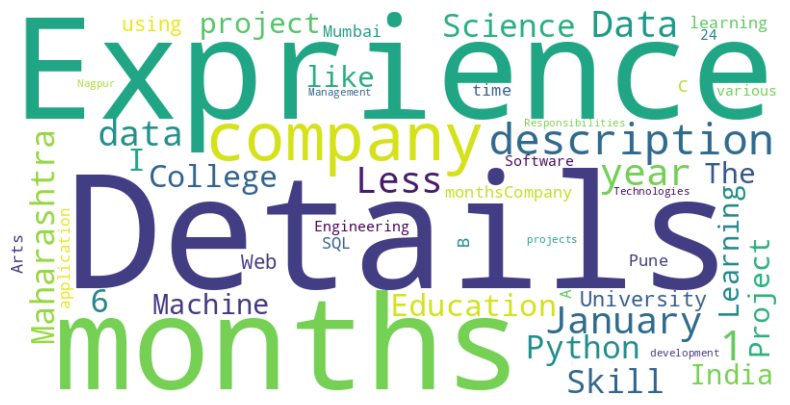

In [65]:
text = dataset['Resume'].values[:160]
top_words = remove_stopwords_pipeline(text)



In [66]:
#converting Words to categorical vlaues
le=LabelEncoder()
dataset['Category']=le.fit_transform(dataset['Category'])
dataset.head()

,Category,Resume,clean_text
0,6,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,6,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,6,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,6,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


In [70]:
#Coverting clean tokens to vector form and split the data into train test
requiredtext=dataset['clean_text'].values
target_column=dataset['Category'].values
word_vectorizer= TfidfVectorizer(sublinear_tf=True, stop_words='english',max_features=5000)
word_vectorizer.fit(requiredtext)
word_features=word_vectorizer.transform(requiredtext)
X_train,X_test,y_train,y_test=train_test_split(word_features,target_column,random_state=42,test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(721, 5000)
(241, 5000)


In [76]:
#Train the model
clf=OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train,y_train)
y_predict=clf.predict(X_test)
print('Accuracy score for knn classifier on training data:{:.2f}'.format(clf.score(X_train,y_train)))
print('Accuracy score for knn classifier on test data:{:.2f}'.format(clf.score(X_test,y_test)))
print("\n Classification report for KNN classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, y_predict)))

Accuracy score for knn classifier on training data:0.99
Accuracy score for knn classifier on test data:0.97

 Classification report for KNN classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         9
           6       0.88      0.78      0.82         9
           7       1.00      0.89      0.94         9
           8       1.00      0.88      0.94        17
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00        15
          13       1.00      1.00    